# Supervised Learning: valideren k-Means clustering 

**HUH??** K-means hoort toch bij **Unsupervised learning**?

Ja dat klopt maar in dit voorbeeld gaan we K-means toepassen op een gelabelde dataset. We gaan valideren hoe dat gaat.

In [1]:
# convenience functions and configuration
%matplotlib inline

import sys
import os
from pathlib import Path
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

# Check Python and library versions
assert sys.version_info >= (3, 7)
# check scikit-learn version
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# helper functions to load Excel files.
# Excel CSV-file
def load_csv_pd_data(path, filename, 
                     names=None, 
                     delim_whitespace=False
                    ):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV file `filename`,
           stored in a folder `path`.
           @names: header-names of columns
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(csv_path)
    return pd.read_csv(csv_path,
                       delim_whitespace=delim_whitespace,
                       names=names,
                      )

# Excel XLS-file
def load_xls_pd_data(path, filename, 
                     names=None
                    ):
    '''
    load_xls_pd_data() - construct a pandas DataFrame object 
           from data in a Excel xls-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    xls_path = os.path.join(path, filename)
    # DEBUG: print(xls_path)
    return pd.read_excel(xls_path,
                         names=names
                        )


# Increase font size for plots
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Create the `images/training_linear_models` folder
IMAGES_PATH = Path() / "images" / "clustering"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Voorbeeld: cijfers clusteren

Dataset: handgeschreven cijfers (digits)

We laten k-Means de dataset clusteren en kijken wat het algoritme vindt.

Dit hebben we eerder gedaan maar we herhalen het 1e gedeelte ....

In [2]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans

# get the digits dataset
# De load_digits() functie van sklearn.datasets laadt de handgeschreven cijfers dataset. 
# Deze dataset bevat afbeeldingen van cijfers (0 tot en met 9) als kleine 8x8 rasterafbeeldingen, samen met hun numerieke labels.
digits = load_digits()

# Omdat we werken met cijfers 0–9, verwachten we dat de gegevens in 10 natuurlijke groepen (clusters) kunnen worden ingedeeld. 
# Elke cluster zou idealiter overeenkomen met één cijfer.
est = KMeans(n_clusters=10)

# fit: Past het KMeans-model aan de gegevens aan (d.w.z. vindt de clusters).
# predict: Wijst elk datapunt (cijfer) toe aan een cluster.
clusters = est.fit_predict(digits.data)
# Het resultaat (clusters) is een array waarin elk element het cluster aangeeft waartoe dat datapunt behoort.

est.cluster_centers_.shape

(10, 64)

Resultaat is 10 clusters in 64 dimensies. Ziet er goed uit! Laten we elk van deze clustercentra visualiseren.

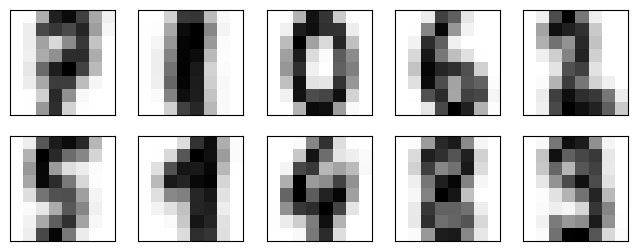

In [3]:
# Dit creëert een nieuwe figuur met een breedte van 8 inch en een hoogte van 3 inch.
# Dit is het canvas waarop de subplots (de clustercentra) worden geplaatst.
fig = plt.figure(figsize=(8, 3))


for i in range(10):
    # Dit verdeelt het canvas in een raster van 2 rijen en 5 kolommen.
    # 1+i: Plaatst elke cluster in een van de 10 subplot-posities.
    # Verwijdert de assentekens (geen getallen op de x- en y-assen).
    ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])

    # Het centrum van het i-de cluster.
    # .reshape((8, 8)): Vormen het 1D-array van 64 waarden (de pixelwaarden van het clustercentrum) om naar een 2D-array van 8x8 (de rastervorm van een cijfer).
    # cmap=plt.cm.binary: Gebruik een zwart-wit kleurenkaart om de clustercentra als afbeeldingen weer te geven.
    ax.imshow(est.cluster_centers_[i].reshape((8,8)), cmap=plt.cm.binary)
    

We zien dat zelfs **zonder de labels** k-Means in staat is clusters te vinden met herkenbare cijfers zijn (wel jammer van het getal 8).

Laten we eens kijken hoe nauwkeurig de k-Means classifier is (zonder labelbevestiging) met een `accuracy_score` en een confusion matrix.

In [4]:
# First, get the labels.
# Because k-Means knows nothing about the identity of the cluster,
# the 0–9 labels may be permuted. We can fix this by matching 
# each learned cluster label with the true labels found in them.


# In de code wordt een mapping gemaakt tussen de KMeans-clusterlabels en de echte labels in de dataset. 
# Dit is nodig omdat KMeans de clusters arbitrair labelt (bijvoorbeeld cluster 0 kan overeenkomen met cijfer 3), en deze labels niet direct overeenkomen met de werkelijke cijfers (0–9).
from scipy.stats import mode
import numpy as np

# clusters: Bevat de clusterindelingen van KMeans voor elke datapunt.
# labels: Een array van dezelfde grootte als clusters, maar gevuld met nullen.
# Dit array zal worden overschreven met de juiste labels (0–9).
labels = np.zeros_like(clusters)

for i in range(10):
    # mask = (clusters == i):
    # Dit maakt een booleaanse array waar de waarde True is voor datapunten die aan cluster i zijn toegewezen.
    # Bijvoorbeeld, als een datapunt is toegewezen aan cluster 3, dan is mask voor dat punt True wanneer i == 3.
    mask = (clusters == i)

    # digits.target[mask]: Dit selecteert de echte labels van de punten die aan cluster i toebehoren.
    # mode(): Berekent de meest voorkomende waarde (de modus) van deze labels, omdat dit het cijfer is dat het cluster het best vertegenwoordigt.
    # keepdims=True: Houdt de uitvoer in de juiste vorm.
    # [0]: Haalt alleen de meest voorkomende waarde (de modus) op, zonder aanvullende details.
    # labels[mask] = ...: Wijst de juiste label (de modus) toe aan alle punten in cluster i.
    labels[mask] = mode(digits.target[mask], keepdims=True)[0]

Waarom is dit ook alweer nodig? 

KMeans zelf kent de identiteit van de clusters niet. Het labelt clusters gewoon als 0, 1, 2, ..., maar deze labels hebben geen betekenis. Door deze labels te matchen met de echte labels, kun je evalueren hoe goed KMeans de cijfers heeft gegroepeerd.

Nu bepalen we de nauwkeurigheid van de clustering door te vergelijken hoe goed de door KMeans bepaalde labels (labels) overeenkomen met de echte labels (digits.target) in de dataset.

In [5]:
from sklearn.metrics import accuracy_score

# digit_targets: Dit zijn de werkelijke labels van de cijfers (0–9). Bijvoorbeeld: [0, 1, 2, 3, 4, ...].
# Dit zijn de labels die je eerder hebt toegewezen aan de clusters, zodat ze zo goed mogelijk overeenkomen met de echte labels.
# De accuracy wordt berekend als het percentage datapunten waarvoor de voorspelde labels (labels) overeenkomen met de echte labels (digits.target).
# De accuracy = totaal aantal datapunten / aantal correcte voorspellingen​.
accuracy_score(digits.target, labels)


0.7924318308291597

Een hoge score (bijvoorbeeld 0.90 of 90%) betekent dat de clustering goed overeenkomt met de echte labels.
Een lage score betekent dat KMeans moeite heeft om de cijfers goed te groeperen.

De score ligt hier onder de 90% dus .. dat is niet zo best ...

Mogelijke oorzaken:
- Omdat KMeans een unsupervised algoritme is, kan de accuracy-score variëren afhankelijk van de initialisatie van de clustercentra (door bijvoorbeeld random_state in te stellen kun je reproduceerbaarheid garanderen).
- Als je dataset overlapt in kenmerken tussen clusters (bijvoorbeeld cijfers als 1 en 7 lijken sterk op elkaar), kan dit de score verlagen.

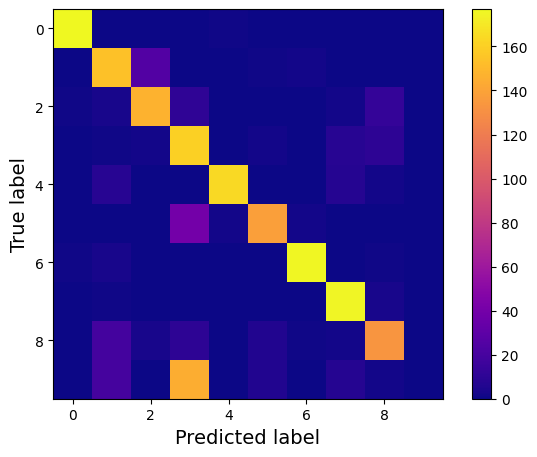

In [6]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# digits.target: De ware labels van de cijfers (0–9).
# labels: De labels die je hebt toegewezen op basis van de KMeans-clustering.
# confusion_matrix: Berekent een matrix die toont hoeveel punten van elk echte label (digits.target) in elk cluster (labels) zijn geplaatst.
# plt.imshow: Toont de confusion matrix als een heatmap.cmap='plasma': Gebruikt de kleurenschaal "plasma" voor de visualisatie.
# interpolation='nearest': Maakt de kleuren in de heatmap scherp (geen vervaging).
plt.imshow(confusion_matrix(digits.target, labels),cmap='plasma', interpolation='nearest')

plt.colorbar()
plt.grid(False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# optional: save plot
save_fig("kMeans_digits_confusionmatrix_1")
plt.show()

De diagonale elementen van de confusion matrix tonen het aantal datapunten dat correct in een cluster is geplaatst.

Hoge waarden buiten de diagonale lijn wijzen op fouten, waar punten verkeerd zijn geclassificeerd.

Zie de code onder ... deze visualiseert de confusion matrix als een heatmap met behulp van seaborn. 

Dit biedt een meer gedetailleerde en leesbare visualisatie dan een eenvoudige imshow van Matplotlib. 

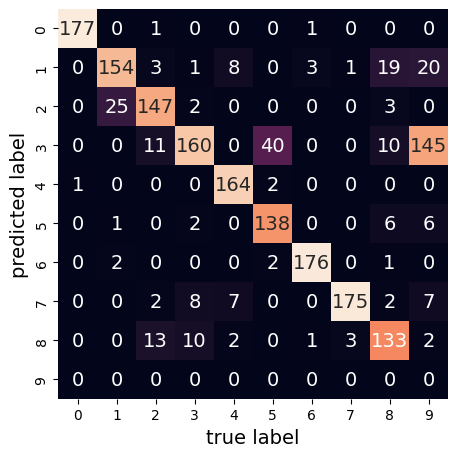

In [7]:
# alternative: confusion as a heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(digits.target, labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names
           )
plt.xlabel('true label')
plt.ylabel('predicted label')

# optional: save plot
save_fig("kMeans_digits_confusionmatrix_heatmap")
plt.show()

De diagonale cellen laten zien hoeveel cijfers correct zijn geclusterd.

Niet-diagonale waarden geven fouten weer: cijfers die verkeerd zijn ingedeeld.

De annotaties (getallen in de cellen) maken het makkelijk om fouten snel te spotten.